In [ ]:
!sudo pip3 install  -U -q geopandas PyMySQL sqlalchemy sql_magic osmnx
!curl 'https://data.cityofnewyork.us/api/geospatial/cpf4-rkhq?method=export&format=GeoJSON' -o nyc-neighborhoods.geojson

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 6.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.8/44.8 kB 4.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 102.9/102.9 kB 9.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 10.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 123.4/123.4 kB 6.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 93.5/93.5 kB 8.6 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
lida 0.0.10 requires fastapi, which is not installed.
lida 0.0.10 requires kaleido, which is not installed.
lida 0.0.10 requires python-multipart, which is not installed.
lida 0.0.10 requires uvicorn, which is not installed.
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  U

In [ ]:
import osmnx as ox
import numpy as np
import pandas as pd
import seaborn as sns
import networkx as nx
import geopandas as gpd
import matplotlib as plt
from sqlalchemy import text
import matplotlib.pyplot as plt
from shapely.geometry import Point
from matplotlib.cm import get_cmap
from sqlalchemy import create_engine

ox.__version__
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [ ]:
conn_string = f"mysql+pymysql://{'student'}:{'dwdstudent2015'}@{'db.ipeirotis.org'}/{'public'}" #{user}:{password}@{host}/{db_name}
engine = create_engine(conn_string)

q1 = "SELECT * FROM public.TeamA_Data_traffic;"
q2 = "SELECT * FROM public.TeamA_Data_construction;"
q3 = "SELECT * FROM public.TeamA_Data_collisions"

with engine.connect() as connection:
  collision_data = pd.read_sql_query(text(q3), connection)

with engine.connect() as connection:
  construction_data = pd.read_sql_query(text(q2), connection)

with engine.connect() as connection:
  traffic_data = pd.read_sql_query(text(q1), connection)

collision_data = collision_data[collision_data['borough'] != '0']
construction_data = construction_data[construction_data['borough'] != '0']


construction_data['data_as_of'] = pd.to_datetime(construction_data['data_as_of'])
construction_data['data_as_of'] = construction_data['data_as_of'].apply(lambda d: d.replace(year=2023))

<ipython-input-3-a2105df8ff63>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  construction_data['data_as_of'] = pd.to_datetime(construction_data['data_as_of'])


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

import pandas as pd
import geopandas as gpd
from shapely.geometry import Point


borough_boundaries_path = '/content/drive/My Drive/new-york-city-boroughs.geojson'
borough_boundaries = gpd.read_file(borough_boundaries_path)

traffic_geo = gpd.GeoDataFrame(traffic_data, geometry=gpd.points_from_xy(traffic_data['longitude'], traffic_data['latitude']))

traffic_geo_with_borough = gpd.sjoin(traffic_geo, borough_boundaries, op='within')

traffic_data['borough'] = traffic_geo_with_borough['name']

Mounted at /content/drive


/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py:3473: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if (await self.run_code(code, result,  async_=asy)):
<ipython-input-4-f238c80351e3>:14: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: None
Right CRS: EPSG:4326

  traffic_geo_with_borough = gpd.sjoin(traffic_geo, borough_boundaries, op='within')


First Interactive Graph

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import ipywidgets as widgets
from IPython.display import display, clear_output

construction_data['borough'] = construction_data['borough'].replace({'STATEN IS': 'STATEN ISLAND'})

traffic_data['borough'] = traffic_data['borough'].str.upper()

dropdown1 = widgets.Dropdown(
    options=collision_data['borough'].unique(),
    description='Borough 1:',
)

dropdown2 = widgets.Dropdown(
    options=collision_data['borough'].unique(),
    description='Borough 2:',
)

date_picker_start = widgets.DatePicker(description='Start Date')
date_picker_end = widgets.DatePicker(description='End Date')

button = widgets.Button(description="Show Graphs")

def display_matplotlib_graphs(borough1, borough2, start_date, end_date):
    clear_output(wait=True)
    display(dropdown1, dropdown2, date_picker_start, date_picker_end, button)

    start_date = pd.to_datetime(start_date)
    end_date = pd.to_datetime(end_date)

    filtered_collision_data = collision_data[(collision_data['borough'].isin([borough1, borough2])) &
                                             (collision_data['crash_date'] >= start_date) &
                                             (collision_data['crash_date'] <= end_date)]
    filtered_construction_data = construction_data[(construction_data['borough'].isin([borough1, borough2])) &
                                                   (construction_data['data_as_of'] >= start_date) &
                                                   (construction_data['data_as_of'] <= end_date)]
    filtered_traffic_data = traffic_data[(traffic_data['borough'].isin([borough1, borough2])) &
                                         (traffic_data['Date'] >= start_date) &
                                         (traffic_data['Date'] <= end_date)]

    collision_counts = filtered_collision_data['borough'].value_counts().reindex([borough1, borough2]).fillna(0)
    construction_counts = filtered_construction_data['borough'].value_counts().reindex([borough1, borough2]).fillna(0)
    traffic_counts = filtered_traffic_data['borough'].value_counts().reindex([borough1, borough2]).fillna(0)

    fig, axes = plt.subplots(1, 3, figsize=(15, 4))

    axes[0].bar(collision_counts.index, collision_counts, color=['blue', 'orange'])
    axes[0].set_title('Collision Counts')
    axes[0].set_ylabel('Counts')
    axes[0].set_xlabel('Borough')

    axes[1].bar(construction_counts.index, construction_counts, color=['blue', 'orange'])
    axes[1].set_title('Construction Counts')
    axes[1].set_ylabel('Counts')
    axes[1].set_xlabel('Borough')

    axes[2].bar(traffic_counts.index, traffic_counts, color=['blue', 'orange'])
    axes[2].set_title('Traffic Counts')
    axes[2].set_ylabel('Counts')
    axes[2].set_xlabel('Borough')

    plt.tight_layout()
    plt.show()

def on_button_clicked(b):
    display_matplotlib_graphs(dropdown1.value, dropdown2.value, date_picker_start.value, date_picker_end.value)

button.on_click(on_button_clicked)

display(dropdown1, dropdown2, date_picker_start, date_picker_end, button)


Dropdown(description='Borough 1:', options=('BROOKLYN', 'MANHATTAN', 'BRONX', 'QUEENS', 'STATEN ISLAND'), valu…

Dropdown(description='Borough 2:', options=('BROOKLYN', 'MANHATTAN', 'BRONX', 'QUEENS', 'STATEN ISLAND'), valu…

DatePicker(value=None, description='Start Date')

DatePicker(value=None, description='End Date')

Button(description='Show Graphs', style=ButtonStyle())

In [ ]:
time_columns = traffic_data.columns[7:31]
traffic_data["Average_volume"] = traffic_data[time_columns].sum(axis=1)/24
df1 = traffic_data.groupby(['latitude', 'longitude', 'Roadway_Name', 'Direction', 'From_St', 'To_St']).agg({
    'Average_volume': 'mean'
}).reset_index()

df2 = construction_data.groupby(["borough", 'latitude', 'longitude', 'consttype', 'buildingid', 'zip_code']).agg({
    'unique_id': 'count',
    'award': 'mean'
}).reset_index()

collision_data['crash_date'] = pd.to_datetime(collision_data['crash_date'])
filtered_crash_data_2023 = collision_data[collision_data['crash_date'].dt.year == 2021]
filtered_crash_data_2023.shape

filtered_crash_data_2023 = filtered_crash_data_2023.dropna()
aggregated_df = filtered_crash_data_2023.groupby(['borough','latitude', 'longitude']).agg({
    'number_of_persons_injured': 'mean',
    'number_of_persons_killed': 'mean',
    'number_of_cyclist_injured': 'mean',
    'number_of_cyclist_killed': 'mean',
    'number_of_motorist_injured': 'mean',
    'number_of_motorist_killed': 'mean'
}).reset_index()
aggregated_df['total_casualties'] = aggregated_df[['number_of_persons_injured', 'number_of_persons_killed',
                                                   'number_of_cyclist_injured', 'number_of_cyclist_killed',
                                                   'number_of_motorist_injured', 'number_of_motorist_killed']].sum(axis=1)
df = aggregated_df[['borough','latitude','longitude','total_casualties']]


import pandas as pd
from sklearn.cluster import KMeans

def clustering(df, n, str_agg):
  selected_features = df[['latitude', 'longitude']]
  selected_features = selected_features.dropna()

  kmeans = KMeans(n_clusters=n, random_state=42)
  df['cluster'] = kmeans.fit_predict(selected_features)

  cluster_centers = pd.DataFrame(kmeans.cluster_centers_, columns=['latitude', 'longitude'])
  df['cluster'] = kmeans.predict(selected_features)

  cluster_statistics = df.groupby('cluster').agg({
      str_agg: 'mean',
      'borough': lambda x: x.mode().iloc[0]
  }).reset_index()

  cluster_info = pd.merge(cluster_centers, cluster_statistics, left_index=True, right_on='cluster')
  df = cluster_info[['latitude', 'longitude', str_agg, 'borough']]
  df = df[(df['latitude'] != 0.000000) & (df['longitude'] != 0.000000)].reset_index(drop=True)

  return df

df3 = clustering(df, 1000, "total_casualties")


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
<ipython-input-6-6fd7af600d3a>:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['cluster'] = kmeans.fit_predict(selected_features)
<ipython-input-6-6fd7af600d3a>:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['cluster'] = kmeans.predict(selected_features)


Second Interactive Graph

In [ ]:
import folium
from folium.plugins import FastMarkerCluster
import random

def plot_collision_on_map(data1, data2, data3, sample_size=None):
    """Visualize collision data on a map using folium."""

    data1 = data1.dropna(subset=['longitude', 'latitude'])
    data2 = data2.dropna(subset=['longitude', 'latitude'])
    data3 = data3.dropna(subset=['longitude', 'latitude'])

    m = folium.Map(location=[40.7128, -74.0060], titles='Visualization for Construction, Collisions and Traffic', zoom_start=20)

    collisions_cluster = FastMarkerCluster([], name='Vehicle Collisions').add_to(m)
    construction_cluster = FastMarkerCluster([], name='Construction Projects').add_to(m)
    traffic_cluster = FastMarkerCluster([], name='Traffic Projects').add_to(m)

    def add_marker_to_cluster(row, cluster, color):
        folium.CircleMarker(
            location=[row['latitude'], row['longitude']],
            radius=5,
            color=color,
            fill=True,
            fill_color=color,
            fill_opacity=0.6
        ).add_to(cluster)

    if sample_size:
        data1 = data1.sample(n=min(sample_size, len(data1)))
        data2 = data2.sample(n=min(sample_size, len(data2)))
        data3 = data3.sample(n=min(sample_size, len(data3)))

    data1.apply(lambda row: add_marker_to_cluster(row, collisions_cluster, 'red'), axis=1)
    data2.apply(lambda row: add_marker_to_cluster(row, construction_cluster, 'blue'), axis=1)
    data3.apply(lambda row: add_marker_to_cluster(row, traffic_cluster, 'green'), axis=1)

    folium.LayerControl().add_to(m)
    return m
map_object = plot_collision_on_map(df3, df2, df1, 1000)
map_object.save('map_with_route.html')
map_object

CONSTRUCTION DATA ANALYSIS

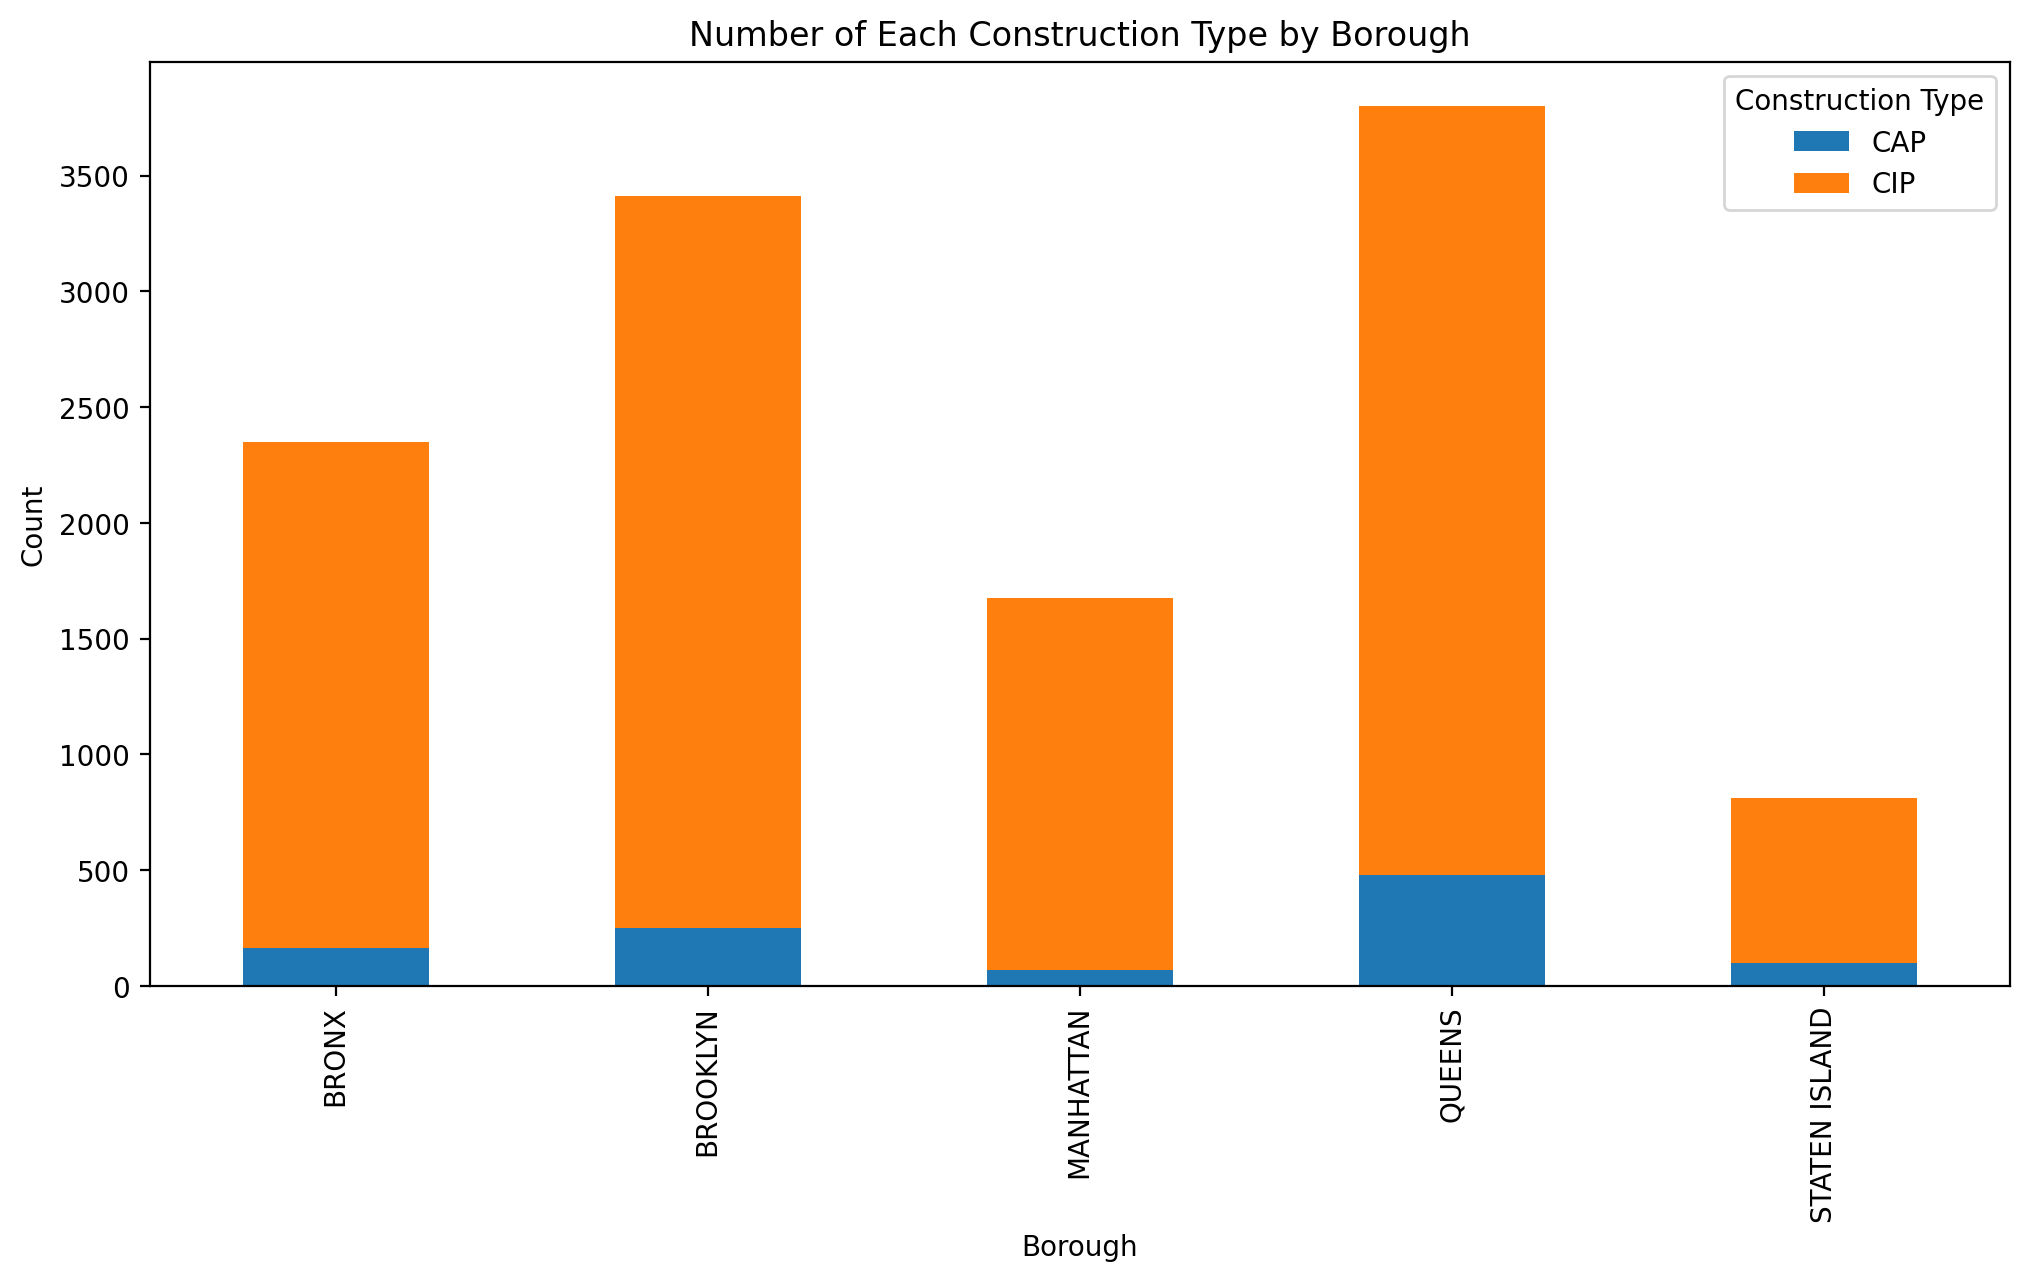

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

construction_type_counts = construction_data.groupby(['borough', 'consttype']).size().unstack()

construction_type_counts.plot(kind='bar', stacked=True, figsize=(12, 6))
plt.title('Number of Each Construction Type by Borough')
plt.xlabel('Borough')
plt.ylabel('Count')
plt.legend(title='Construction Type')
plt.show()


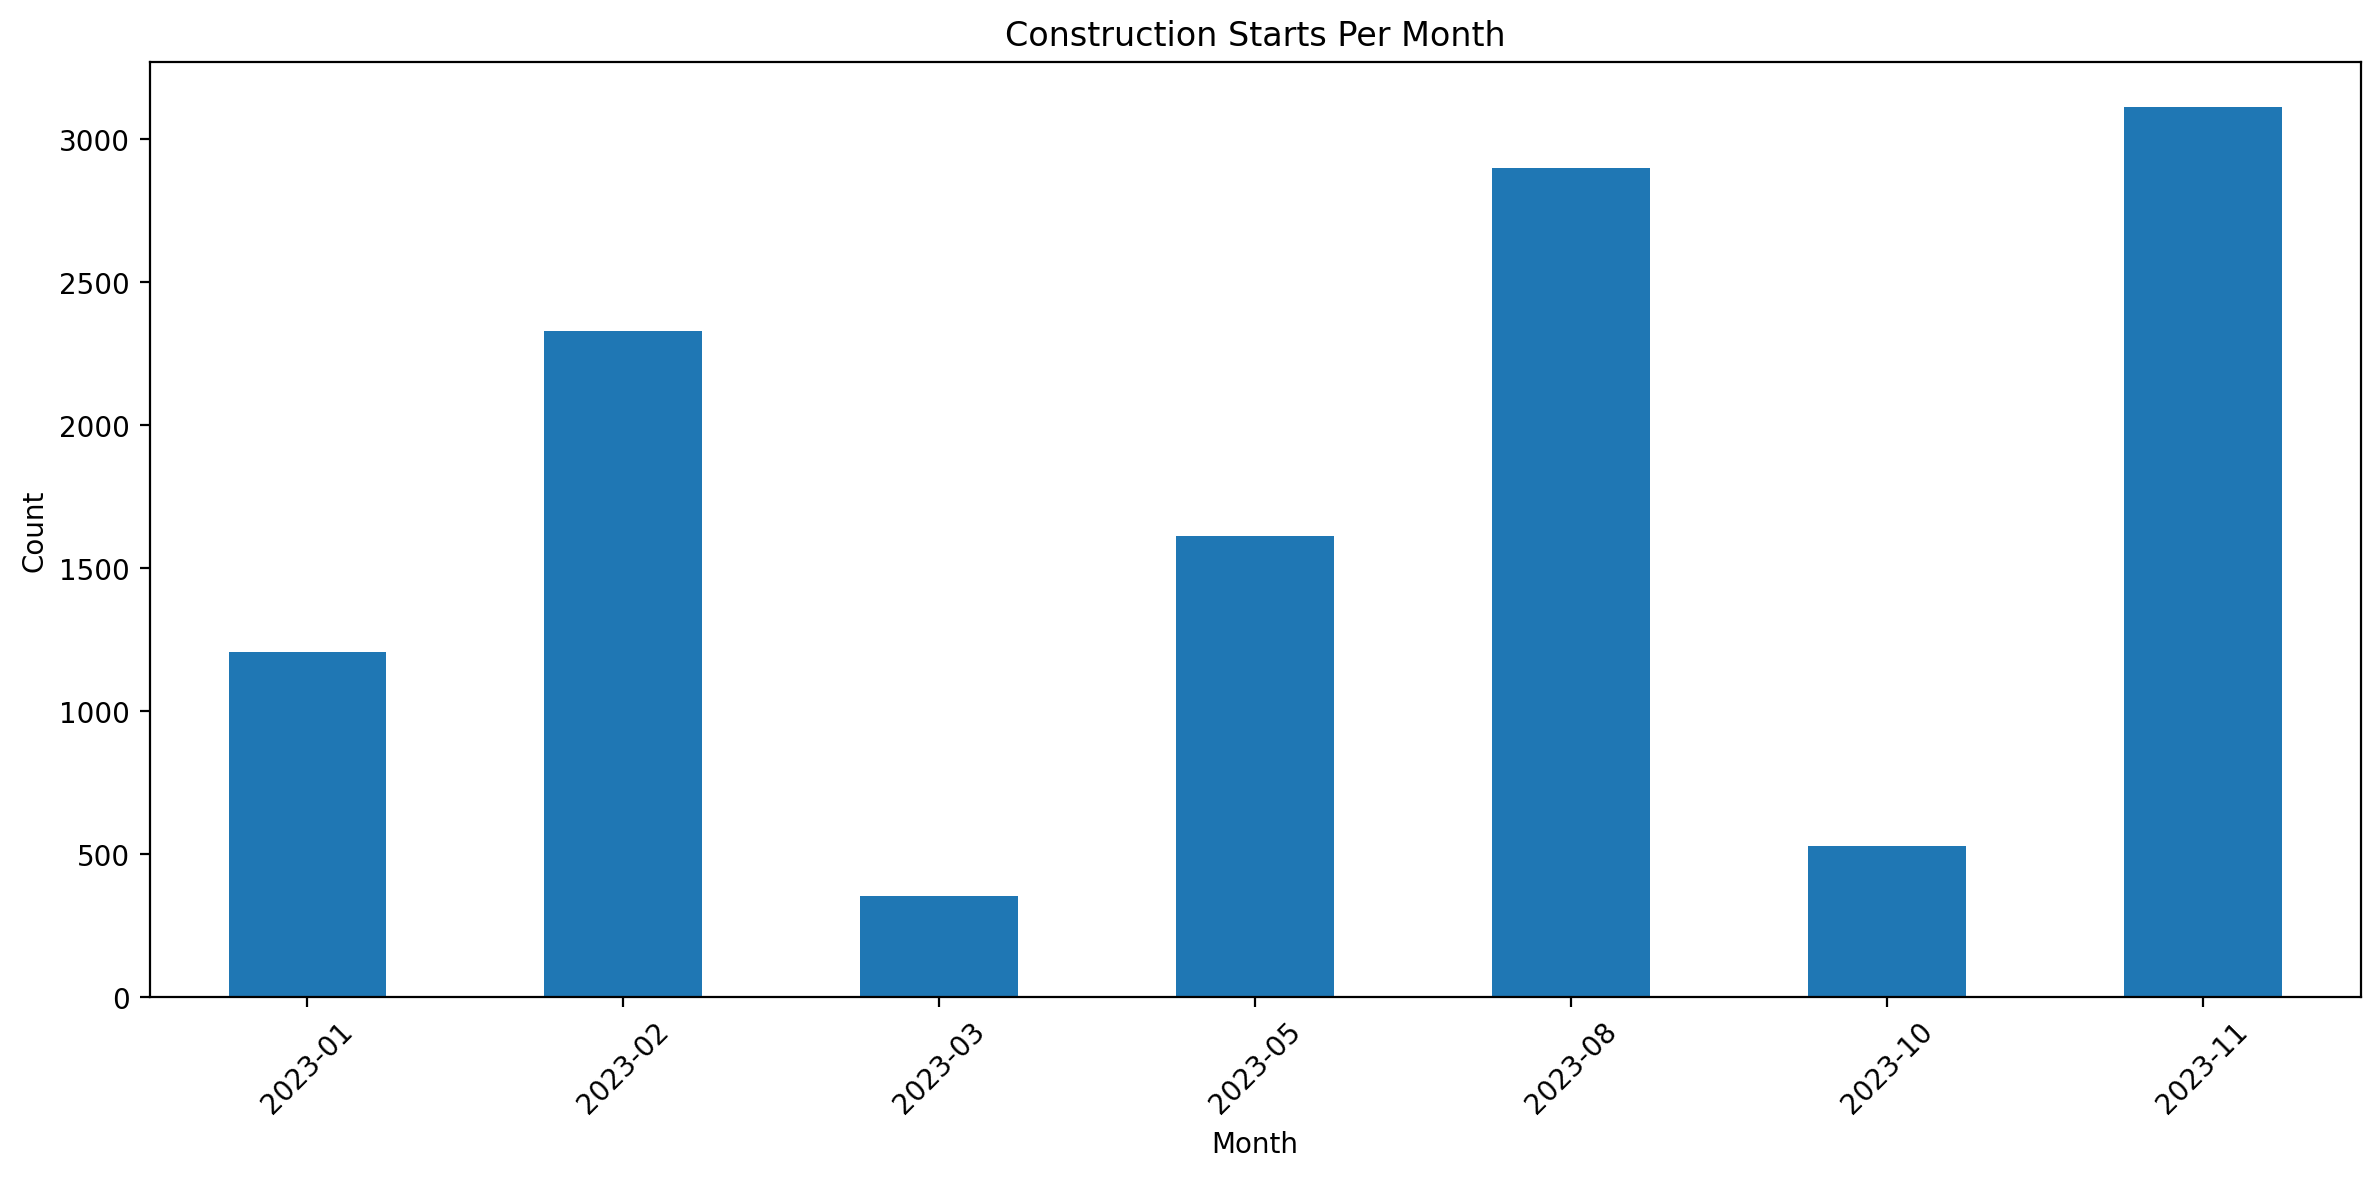

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

construction_data['data_as_of'] = pd.to_datetime(construction_data['data_as_of'])

construction_counts = construction_data['data_as_of'].dt.to_period('M').value_counts().sort_index()

plt.figure(figsize=(12, 6))
construction_counts.plot(kind='bar')
plt.title('Construction Starts Per Month')
plt.xlabel('Month')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


COLLISIONS DATA ANALYSIS

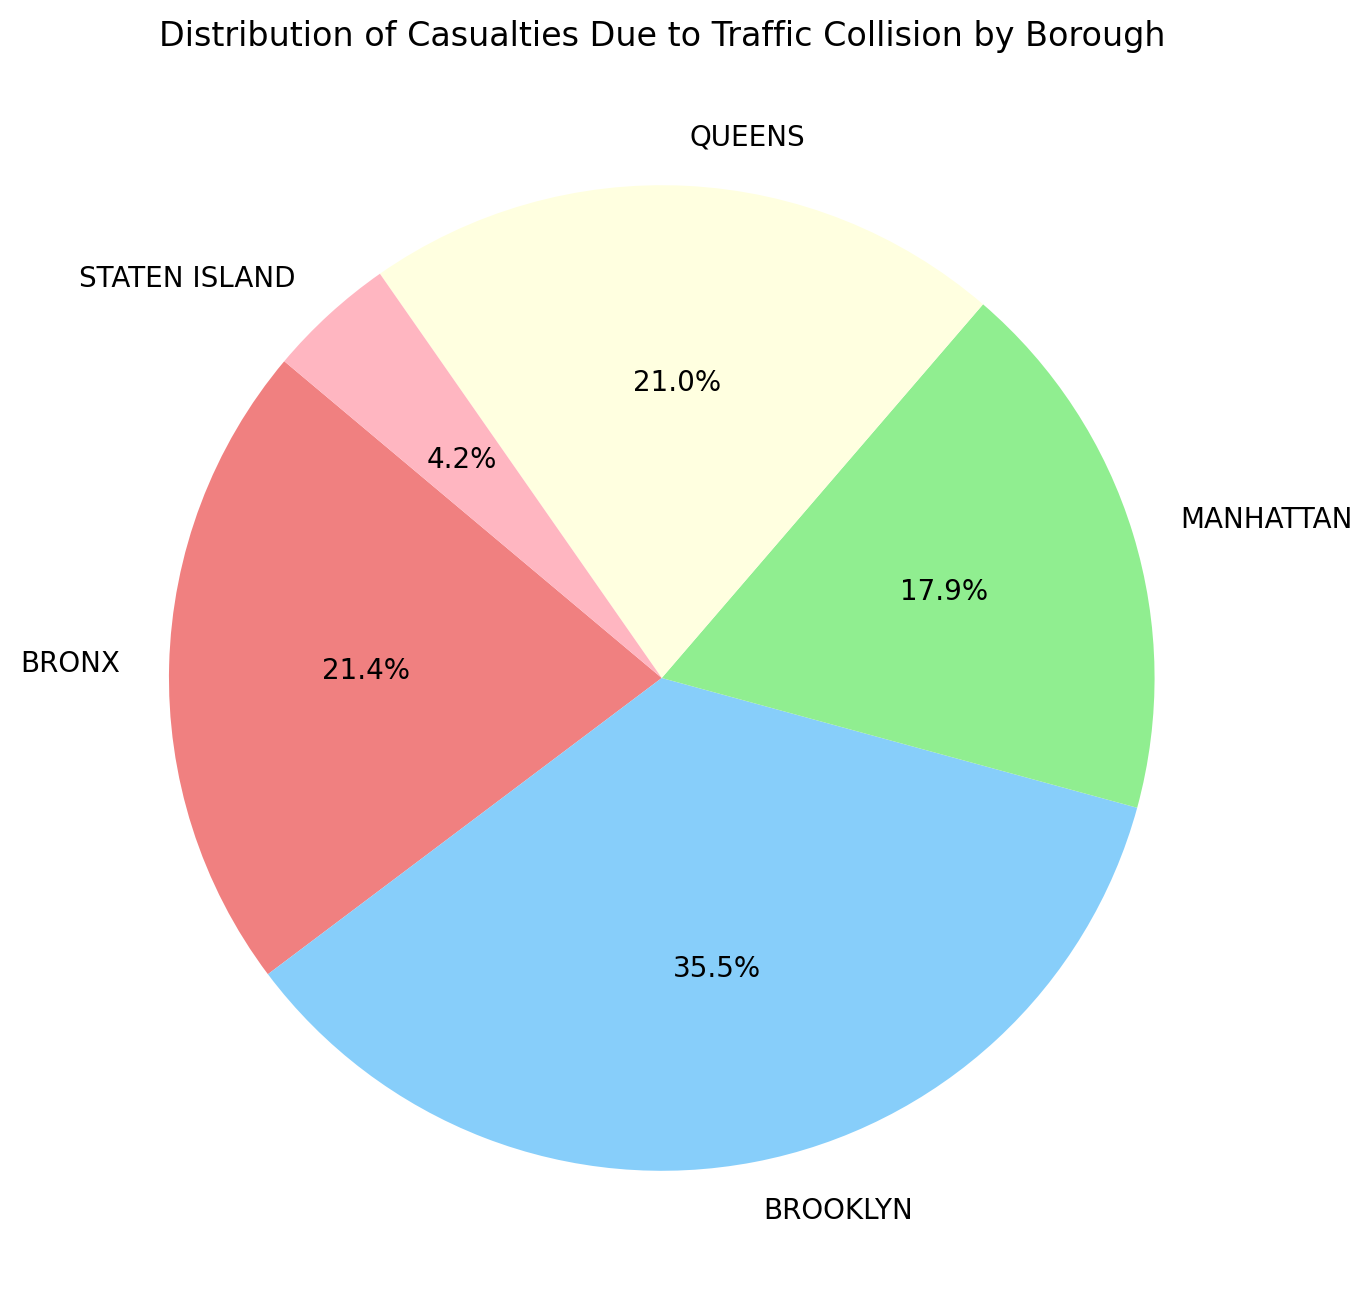

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

borough_casualties = collision_data.groupby('borough')['number_of_persons_killed'].sum()

plt.figure(figsize=(8, 8))
plt.pie(borough_casualties, labels=borough_casualties.index, autopct='%1.1f%%', startangle=140, colors=['lightcoral', 'lightskyblue', 'lightgreen', 'lightyellow', 'lightpink'])
plt.title('Distribution of Casualties Due to Traffic Collision by Borough')
plt.show()


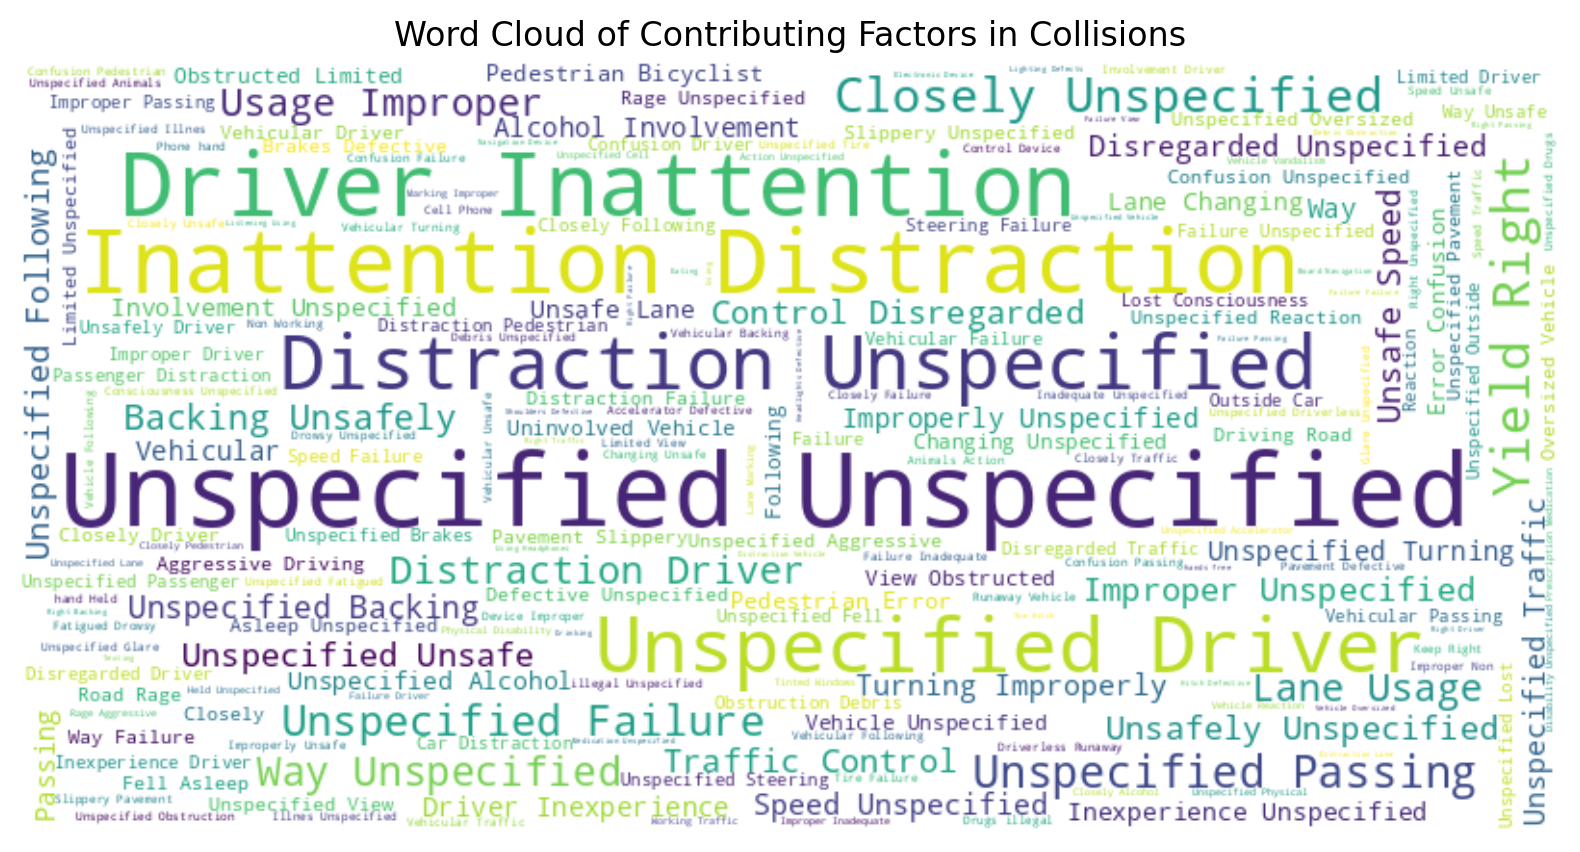

In [ ]:
from wordcloud import WordCloud

contributing_factors = collision_data['contributing_factor_vehicle_1'].str.cat(collision_data['contributing_factor_vehicle_2'], sep=', ')
contributing_factors = contributing_factors.dropna()

wordcloud = WordCloud(width=800, height=400, background_color='white').generate(' '.join(contributing_factors))

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.title('Word Cloud of Contributing Factors in Collisions')
plt.axis('off')
plt.show()


TRAFFIC DATA ANALYSIS

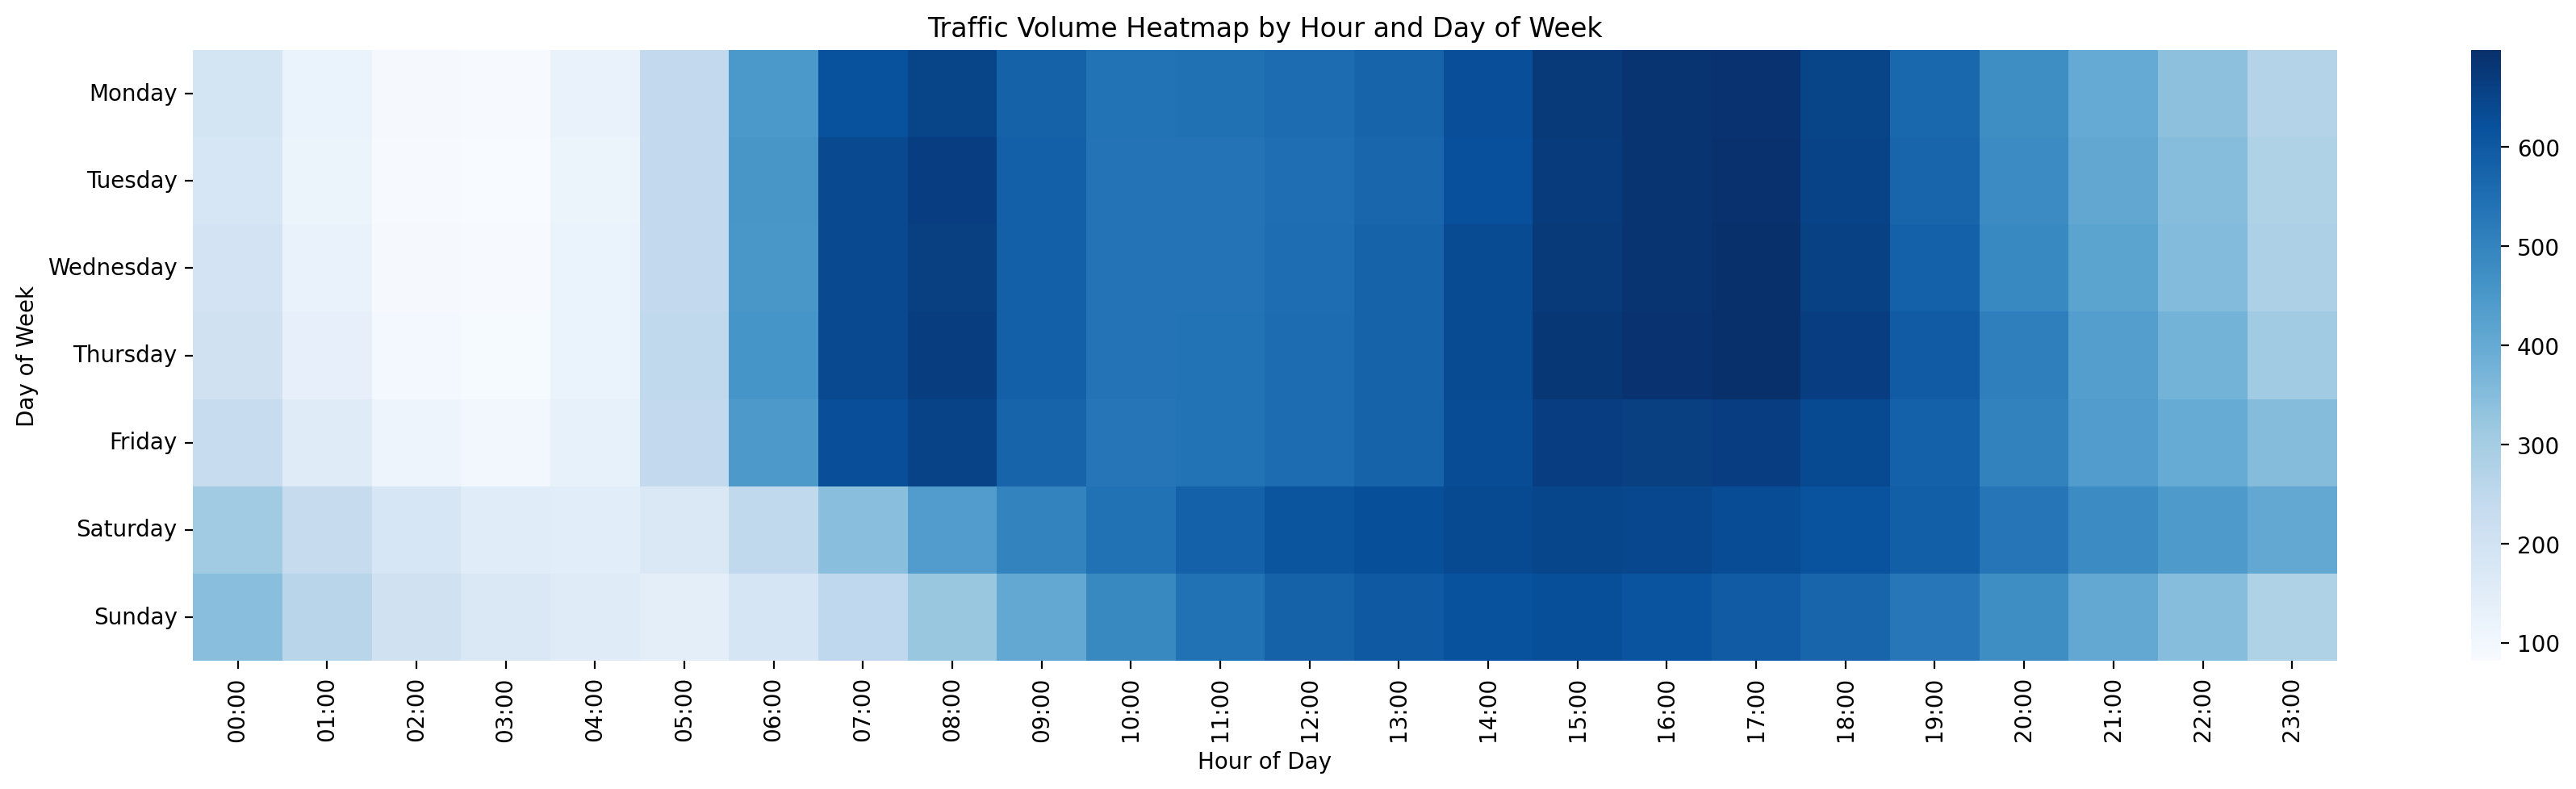

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


traffic_data_copy = traffic_data.copy()


traffic_data_copy['Date'] = pd.to_datetime(traffic_data_copy['Date'])
traffic_data_copy['DayOfWeek'] = traffic_data_copy['Date'].dt.day_name()


day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
traffic_data_copy['DayOfWeek'] = pd.Categorical(traffic_data_copy['DayOfWeek'], categories=day_order, ordered=True)


traffic_data_copy.columns = traffic_data_copy.columns.str.strip()


hour_rename = {
    '_12_00_1_00_am': '00:00', '_1_00_2_00am': '01:00', '_2_00_3_00am': '02:00',
    '_3_00_4_00am': '03:00', '_4_00_5_00am': '04:00', '_5_00_6_00am': '05:00',
    '_6_00_7_00am': '06:00', '_7_00_8_00am': '07:00', '_8_00_9_00am': '08:00',
    '_9_00_10_00am': '09:00', '_10_00_11_00am': '10:00', '_11_00_12_00pm': '11:00',
    '_12_00_1_00pm': '12:00', '_1_00_2_00pm': '13:00', '_2_00_3_00pm': '14:00',
    '_3_00_4_00pm': '15:00', '_4_00_5_00pm': '16:00', '_5_00_6_00pm': '17:00',
    '_6_00_7_00pm': '18:00', '_7_00_8_00pm': '19:00', '_8_00_9_00pm': '20:00',
    '_9_00_10_00pm': '21:00', '_10_00_11_00pm': '22:00', '_11_00_12_00am': '23:00'
}

traffic_data_copy.rename(columns=hour_rename, inplace=True)


hour_columns = list(hour_rename.values())
traffic_data_long = traffic_data_copy.melt(id_vars=['DayOfWeek', 'Date'], value_vars=hour_columns, var_name='Hour', value_name='TrafficVolume')


pivot_table = traffic_data_long.pivot_table(index='DayOfWeek', columns='Hour', values='TrafficVolume', aggfunc='mean')


plt.figure(figsize=(18, 5))
sns.heatmap(pivot_table, cmap='Blues', annot=False)

plt.title('Traffic Volume Heatmap by Hour and Day of Week')
plt.ylabel('Day of Week')
plt.xlabel('Hour of Day')


plt.xticks(rotation=90)
plt.yticks(rotation=0)

plt.tight_layout()
plt.show()


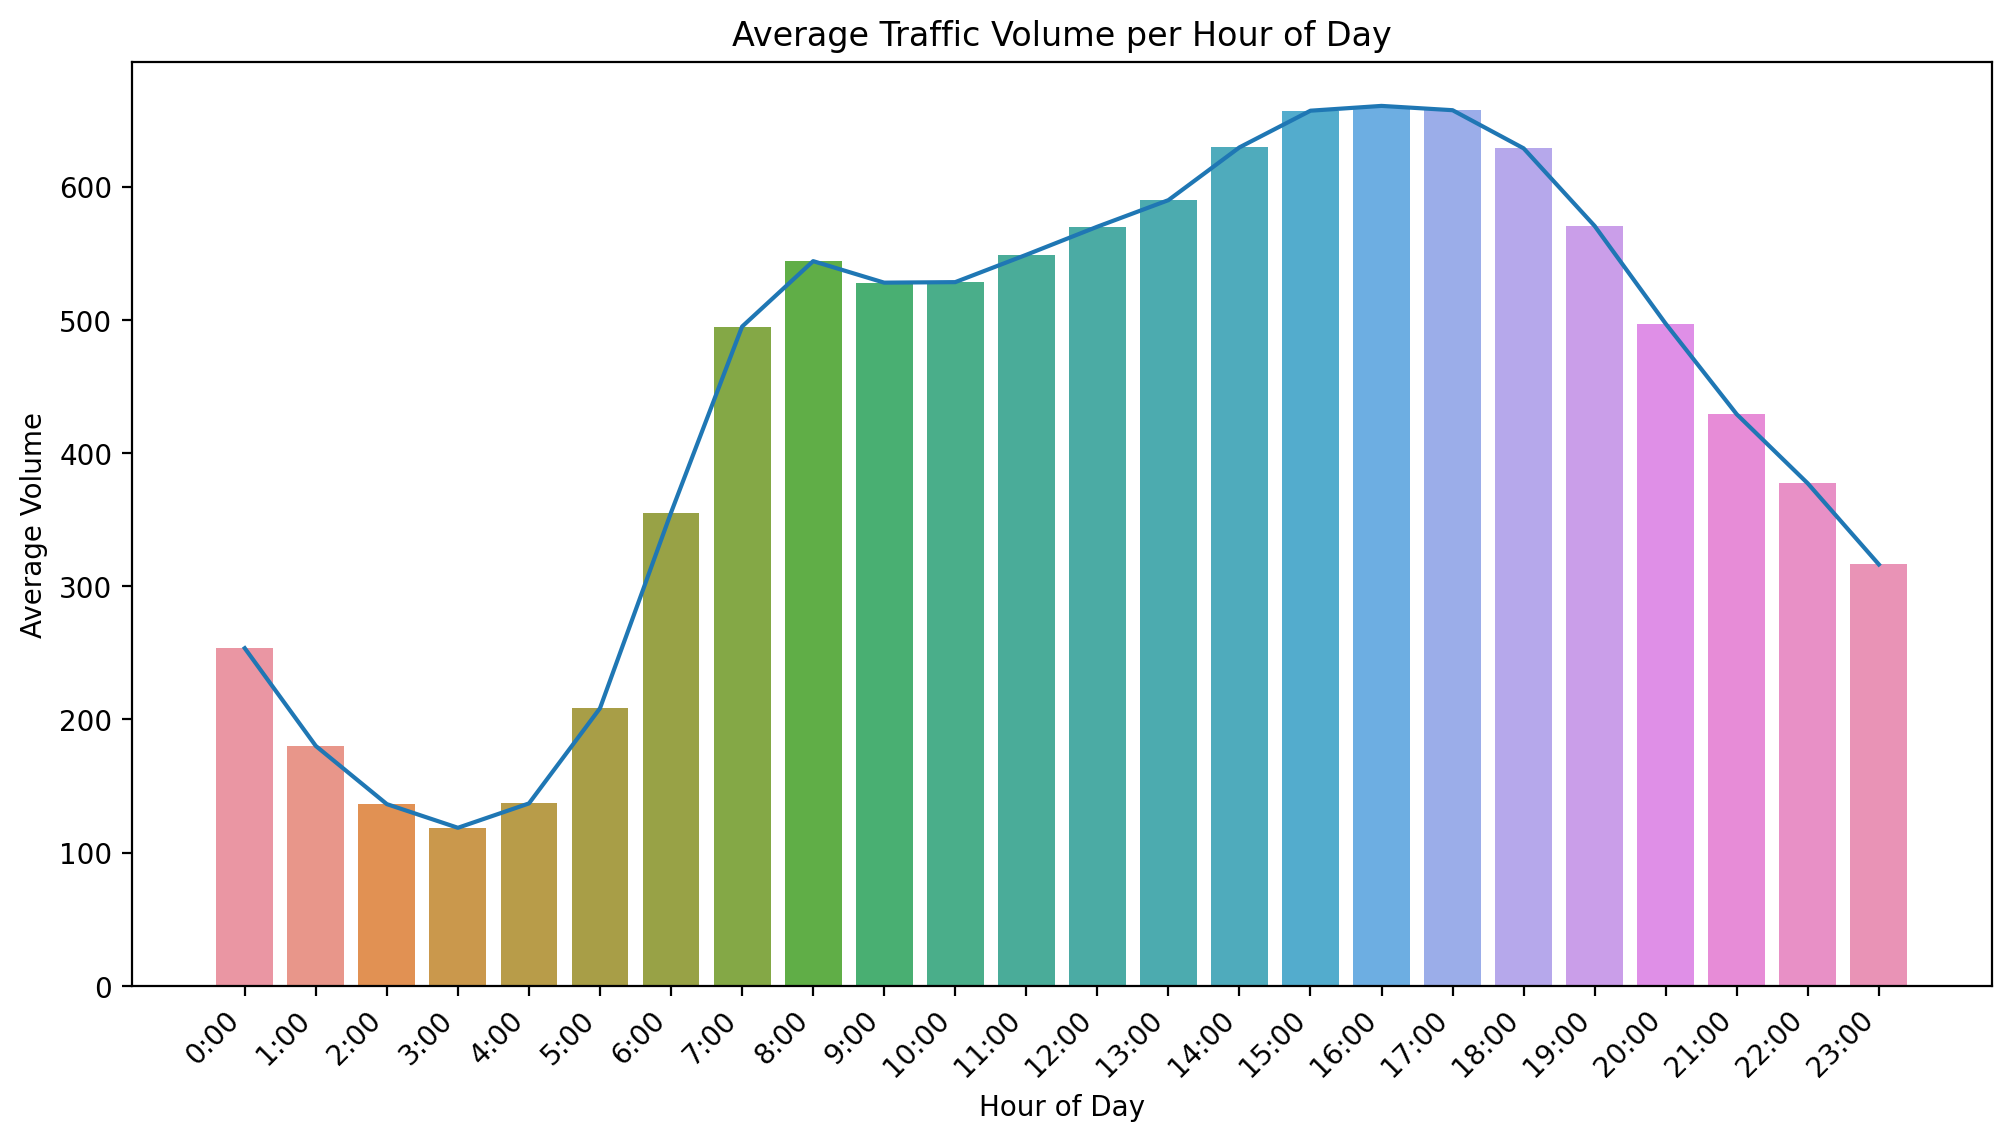

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd


hourly_columns = [
    '_12_00_1_00_am', '_1_00_2_00am', '_2_00_3_00am', '_3_00_4_00am',
    '_4_00_5_00am', '_5_00_6_00am', '_6_00_7_00am', '_7_00_8_00am',
    '_8_00_9_00am', '_9_00_10_00am', '_10_00_11_00am', '_11_00_12_00pm',
    '_12_00_1_00pm', '_1_00_2_00pm', '_2_00_3_00pm', '_3_00_4_00pm',
    '_4_00_5_00pm', '_5_00_6_00pm', '_6_00_7_00pm', '_7_00_8_00pm',
    '_8_00_9_00pm', '_9_00_10_00pm', '_10_00_11_00pm', '_11_00_12_00am'
]

average_volume_per_hour = traffic_data[hourly_columns].mean()

hour_labels = [f'{i}:00' for i in range(24)]

average_volume_df = pd.DataFrame({'Hour': hour_labels, 'Average_volume': average_volume_per_hour.values})

plt.figure(figsize=(12, 6))
sns.barplot(x='Hour', y='Average_volume', data=average_volume_df)

sns.lineplot(x='Hour', y='Average_volume', data=average_volume_df, sort=False)

plt.title('Average Traffic Volume per Hour of Day')
plt.xlabel('Hour of Day')
plt.ylabel('Average Volume')
plt.xticks(rotation=45, ha='right')

plt.show()


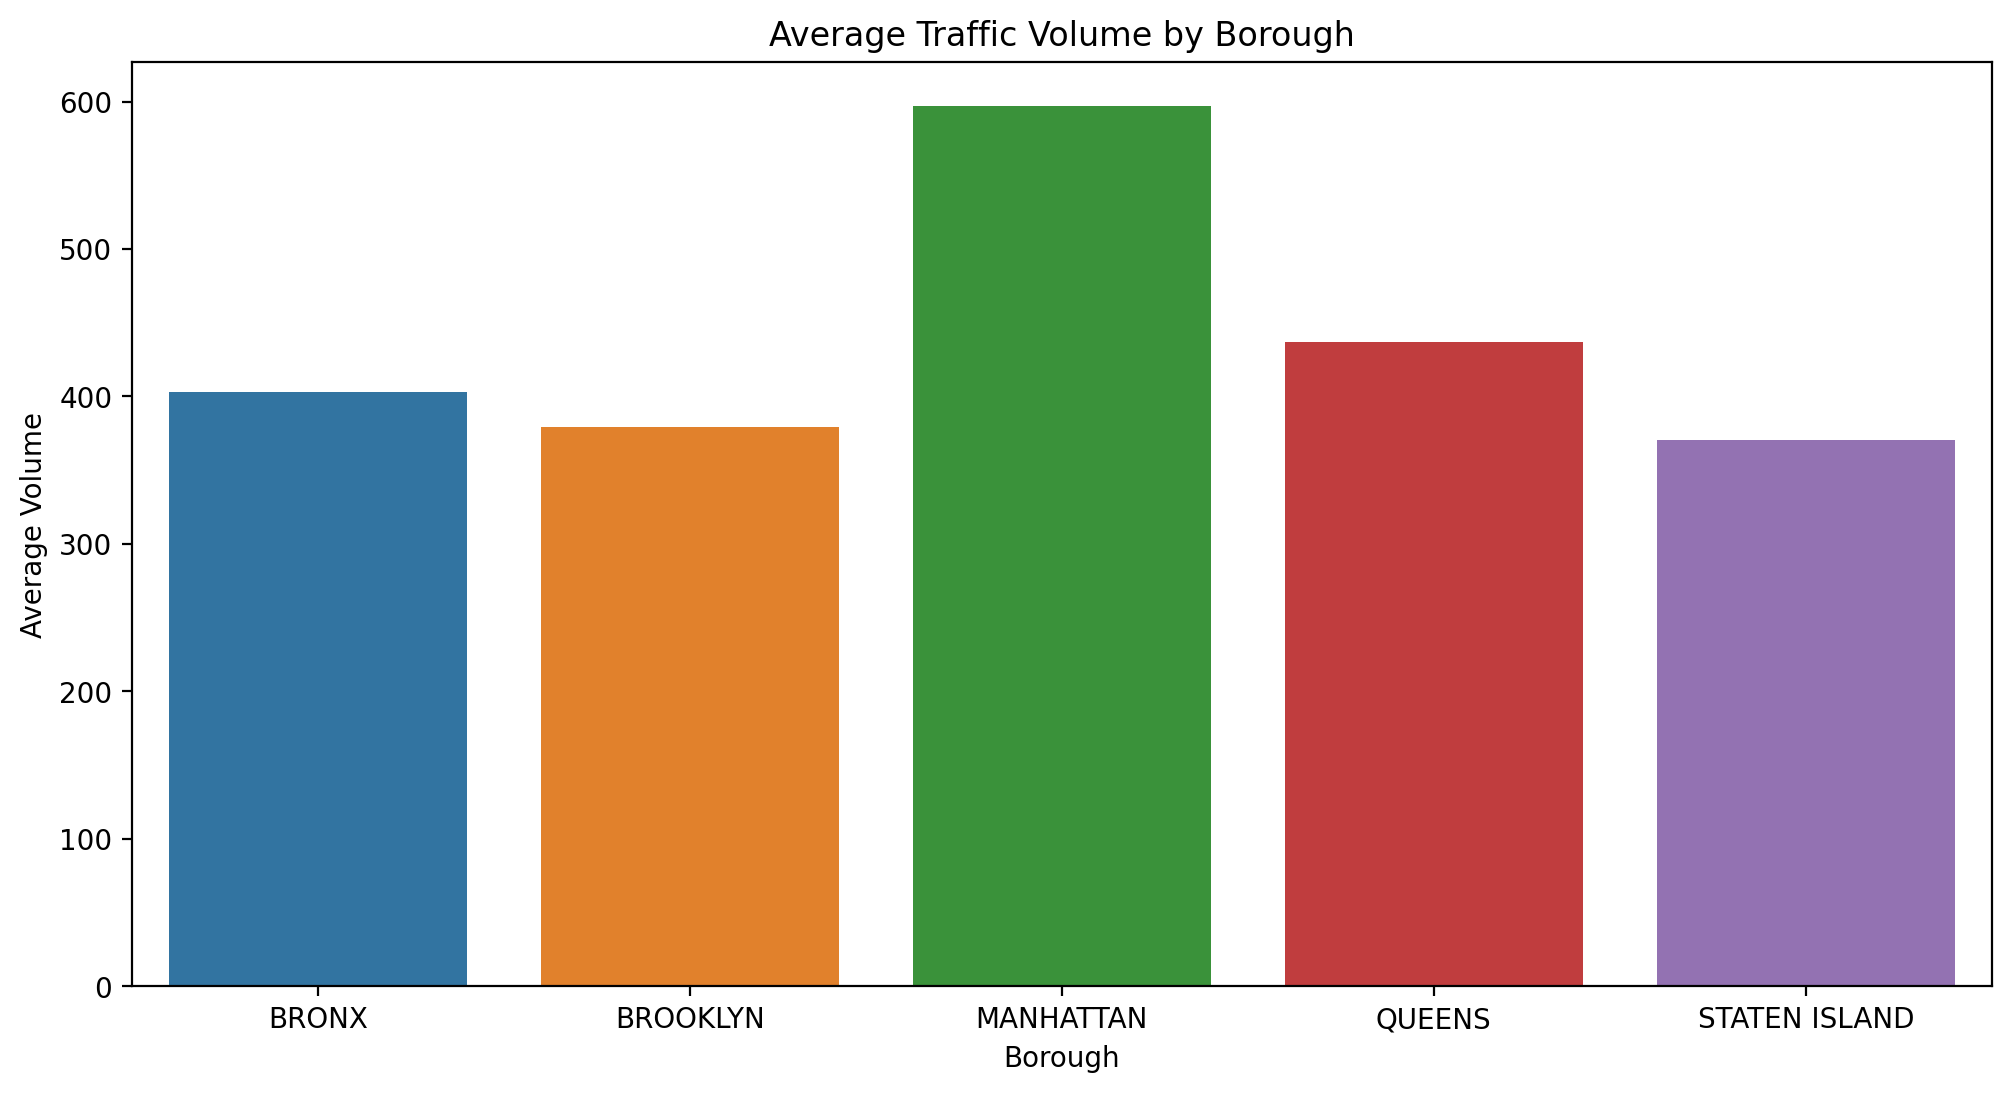

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

borough_volume = traffic_data.groupby('borough')['Average_volume'].mean().reset_index()

plt.figure(figsize=(12, 6))
sns.barplot(x='borough', y='Average_volume', data=borough_volume)
plt.title('Average Traffic Volume by Borough')
plt.xlabel('Borough')
plt.ylabel('Average Volume')
plt.show()


Export for HTML (FLASK)

In [ ]:
import base64
from io import BytesIO
import pandas as pd
import matplotlib.pyplot as plt
from flask import Flask, jsonify
from wordcloud import WordCloud

app = Flask(__name__)


@app.route('/construction_types_by_borough', methods=['GET'])
def construction_types_by_borough():
    construction_type_counts = construction_data.groupby(['borough', 'consttype']).size().unstack()
    construction_type_counts.plot(kind='bar', stacked=True, figsize=(12, 6))
    plt.title('Number of Each Construction Type by Borough')
    plt.xlabel('Borough')
    plt.ylabel('Count')
    plt.legend(title='Construction Type')

    return jsonify({"image": save_plot_to_base64()})

@app.route('/construction_starts_per_month', methods=['GET'])
def construction_starts_per_month():
    construction_data['data_as_of'] = pd.to_datetime(construction_data['data_as_of'])
    construction_counts = construction_data['data_as_of'].dt.to_period('M').value_counts().sort_index()

    plt.figure(figsize=(12, 6))
    construction_counts.plot(kind='bar')
    plt.title('Construction Starts Per Month')
    plt.xlabel('Month')
    plt.ylabel('Count')
    plt.xticks(rotation=45)
    plt.tight_layout()

    return jsonify({"image": save_plot_to_base64()})

@app.route('/casualties_by_borough', methods=['GET'])
def casualties_by_borough():
    borough_casualties = collision_data.groupby('borough')['number_of_persons_killed'].sum()

    plt.figure(figsize=(8, 8))
    plt.pie(borough_casualties, labels=borough_casualties.index, autopct='%1.1f%%', startangle=140, colors=['lightcoral', 'lightskyblue', 'lightgreen', 'lightyellow', 'lightpink'])
    plt.title('Distribution of Casualties Due to Traffic Collision by Borough')

    return jsonify({"image": save_plot_to_base64()})

@app.route('/collision_wordcloud', methods=['GET'])
def collision_wordcloud():
    contributing_factors = collision_data['contributing_factor_vehicle_1'].str.cat(collision_data['contributing_factor_vehicle_2'], sep=', ')
    contributing_factors = contributing_factors.dropna()
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(' '.join(contributing_factors))

    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title('Word Cloud of Contributing Factors in Collisions')
    plt.axis('off')

    return jsonify({"image": save_plot_to_base64()})


@app.route('/traffic_volume_heatmap', methods=['GET'])
def traffic_volume_heatmap():
    traffic_data_copy = traffic_data.copy()
    traffic_data_copy['Date'] = pd.to_datetime(traffic_data_copy['Date'])
    traffic_data_copy['DayOfWeek'] = traffic_data_copy['Date'].dt.day_name()

    day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
    traffic_data_copy['DayOfWeek'] = pd.Categorical(traffic_data_copy['DayOfWeek'], categories=day_order, ordered=True)
    traffic_data_copy.columns = traffic_data_copy.columns.str.strip()

    hour_rename = {
        '_12_00_1_00_am': '00:00', '_1_00_2_00am': '01:00', '_2_00_3_00am': '02:00',
        '_3_00_4_00am': '03:00', '_4_00_5_00am': '04:00', '_5_00_6_00am': '05:00',
        '_6_00_7_00am': '06:00', '_7_00_8_00am': '07:00', '_8_00_9_00am': '08:00',
        '_9_00_10_00am': '09:00', '_10_00_11_00am': '10:00', '_11_00_12_00pm': '11:00',
        '_12_00_1_00pm': '12:00', '_1_00_2_00pm': '13:00', '_2_00_3_00pm': '14:00',
        '_3_00_4_00pm': '15:00', '_4_00_5_00pm': '16:00', '_5_00_6_00pm': '17:00',
        '_6_00_7_00pm': '18:00', '_7_00_8_00pm': '19:00', '_8_00_9_00pm': '20:00',
        '_9_00_10_00pm': '21:00', '_10_00_11_00pm': '22:00', '_11_00_12_00am': '23:00'
    }
    traffic_data_copy.rename(columns=hour_rename, inplace=True)

    hour_columns = list(hour_rename.values())
    traffic_data_long = traffic_data_copy.melt(id_vars=['DayOfWeek', 'Date'], value_vars=hour_columns, var_name='Hour', value_name='TrafficVolume')
    pivot_table = traffic_data_long.pivot_table(index='DayOfWeek', columns='Hour', values='TrafficVolume', aggfunc='mean')

    plt.figure(figsize=(18, 5))
    sns.heatmap(pivot_table, cmap='Blues', annot=False)
    plt.title('Traffic Volume Heatmap by Hour and Day of Week')
    plt.ylabel('Day of Week')
    plt.xlabel('Hour of Day')
    plt.xticks(rotation=90)
    plt.yticks(rotation=0)
    plt.tight_layout()

    return jsonify({"image": save_plot_to_base64()})

@app.route('/average_traffic_volume', methods=['GET'])
def average_traffic_volume():
    hourly_columns = [
        '_12_00_1_00_am', '_1_00_2_00am', '_2_00_3_00am', '_3_00_4_00am',
        '_4_00_5_00am', '_5_00_6_00am', '_6_00_7_00am', '_7_00_8_00am',
        '_8_00_9_00am', '_9_00_10_00am', '_10_00_11_00am', '_11_00_12_00pm',
        '_12_00_1_00pm', '_1_00_2_00pm', '_2_00_3_00pm', '_3_00_4_00pm',
        '_4_00_5_00pm', '_5_00_6_00pm', '_6_00_7_00pm', '_7_00_8_00pm',
        '_8_00_9_00pm', '_9_00_10_00pm', '_10_00_11_00pm', '_11_00_12_00am'
    ]

    average_volume_per_hour = traffic_data[hourly_columns].mean()
    hour_labels = [f'{i}:00' for i in range(24)]
    average_volume_df = pd.DataFrame({'Hour': hour_labels, 'Average_volume': average_volume_per_hour.values})

    plt.figure(figsize=(12, 6))
    sns.barplot(x='Hour', y='Average_volume', data=average_volume_df)
    sns.lineplot(x='Hour', y='Average_volume', data=average_volume_df, sort=False)

    plt.title('Average Traffic Volume per Hour of Day')
    plt.xlabel('Hour of Day')
    plt.ylabel('Average Volume')
    plt.xticks(rotation=45, ha='right')

    return jsonify({"image": save_plot_to_base64()})

@app.route('/average_volume_by_borough', methods=['GET'])
def average_volume_by_borough():
    borough_volume = traffic_data.groupby('borough')['Average_volume'].mean().reset_index()

    plt.figure(figsize=(12, 6))
    sns.barplot(x='borough', y='Average_volume', data=borough_volume)
    plt.title('Average Traffic Volume by Borough')
    plt.xlabel('Borough')
    plt.ylabel('Average Volume')

    return jsonify({"image": save_plot_to_base64()})

def save_plot_to_base64():
    buf = BytesIO()
    plt.savefig(buf, format="png")
    buf.seek(0)
    plot_url = base64.b64encode(buf.read()).decode('utf-8')
    buf.close()
    plt.clf()
    return plot_url

if __name__ == '__main__':
    app.run(debug=True)



 * Serving Flask app '__main__'
 * Debug mode: on


INFO:werkzeug:WARNING: This is a development server. Do not use it in a production deployment. Use a production WSGI server instead.
 * Running on http://127.0.0.1:5000
INFO:werkzeug:Press CTRL+C to quit
INFO:werkzeug: * Restarting with stat
